In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

[Hastie, Tibshirani, Friedman, Ex. 10.2]

$$
X\in{\rm R}^d,
\quad
y\in\{0,1\},
\quad
X\sim{\rm N}(0, {\bf I}),
\quad
y = 1 \Leftrightarrow \sum_{j=1}^d x_j^2 \le \chi^2_d(0.5) \approx 9.34,
\quad
d = 10
$$

In [2]:
from sklearn.datasets import make_hastie_10_2
N_train = 10000
N_test  =  2000
X_train, y_train = make_hastie_10_2(n_samples = N_train, random_state = 0)
X_test,  y_test  = make_hastie_10_2(n_samples = N_test,  random_state = 1)
y_train[y_train ==  1] = 0
y_train[y_train == -1] = 1
y_test [y_test  ==  1] = 0
y_test [y_test  == -1] = 1
y_train = y_train.astype(int)
y_test  = y_test.astype(int)

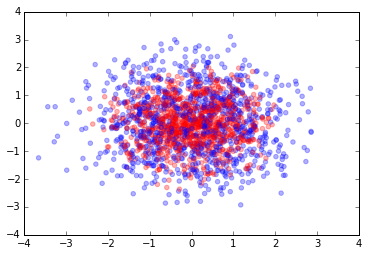

In [3]:
plt.scatter(X_test[:, 0], X_test[:, 1], color = np.array(('b', 'r'))[y_test], alpha = 0.3)

## Decision Tree

In [4]:
from sklearn import tree
dt_model = tree.DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
err_tree_train = np.mean(y_train != dt_model.predict(X_train))
err_tree_test  = np.mean(y_test  != dt_model.predict(X_test))
print(err_tree_train, err_tree_test)

0.0 0.2195


In [5]:
stump_model = tree.DecisionTreeClassifier(max_depth = 1)
stump_model.fit(X_train, y_train)
err_stump_train = np.mean(y_train != stump_model.predict(X_train))
err_stump_test  = np.mean(y_test  != stump_model.predict(X_test))
print(err_stump_train, err_stump_test)

0.4574 0.4565


##GBT - Gradient Boosted Trees

In [6]:
from sklearn import ensemble

In [7]:
n_estimators = 2000 # 50000
gbt_model = ensemble.GradientBoostingClassifier(n_estimators = n_estimators, max_depth = 1)
gbt_model.fit(X_train, y_train)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=1, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2, n_estimators=2000,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [8]:
gbt_model.staged_predict(X_train)

<generator object staged_predict at 0x0000000016306E10>

In [9]:
err_gbt_train = []
for y_train_pred in gbt_model.staged_predict(X_train):
    err_gbt_train.append(np.mean(y_train_pred != y_train))
    
err_gbt_test = []
for y_test_pred in gbt_model.staged_predict(X_test):
    err_gbt_test.append(np.mean(y_test_pred != y_test))
  

In [10]:
print(min(err_gbt_test), np.argmin(err_gbt_test) + 1)

0.0415 1938


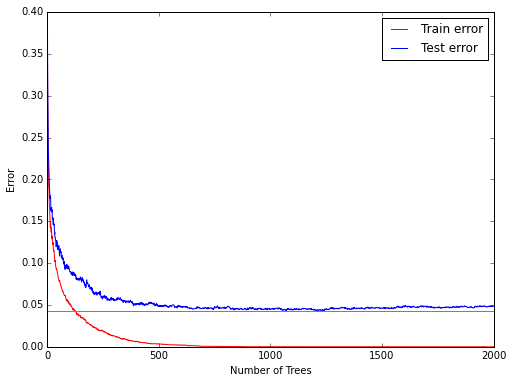

In [31]:
plt.figure(figsize = (8, 6))
plt.plot(range(1, n_estimators + 1), err_gbt_train, 'r', label = 'Train error')
plt.plot(range(1, n_estimators + 1), err_gbt_test,  'b', label = 'Test error')
plt.legend(loc = 1)
plt.axhline(y = min(err_gbt_test), color = 'gray')
plt.xlabel('Number of Trees')
plt.ylabel('Error')

##AdaBoost

In [11]:
ada_model = ensemble.AdaBoostClassifier(n_estimators = n_estimators)
ada_model.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=2000, random_state=None)

In [12]:
err_ada_train = []
for y_train_pred in ada_model.staged_predict(X_train):
    err_ada_train.append(np.mean(y_train_pred != y_train))
    
err_ada_test = []
for y_test_pred in ada_model.staged_predict(X_test):
    err_ada_test.append(np.mean(y_test_pred != y_test))

In [13]:
print(min(err_ada_test), np.argmin(err_ada_test) + 1)

0.0235 1363


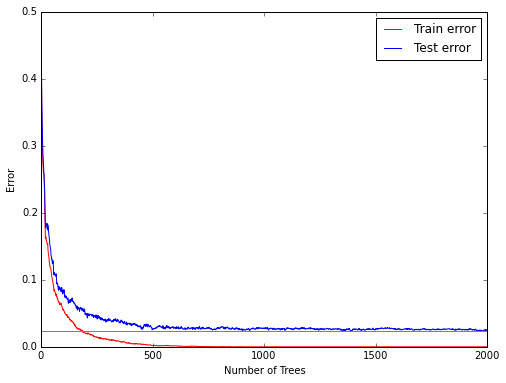

In [14]:
plt.figure(figsize = (8, 6))
plt.plot(range(1, n_estimators + 1), err_ada_train, 'r', label = 'Train error')
plt.plot(range(1, n_estimators + 1), err_ada_test,  'b', label = 'Test error')
plt.legend(loc = 1)
plt.axhline(y = min(err_ada_test), color = 'gray')
plt.xlabel('Number of Trees')
plt.ylabel('Error')

## Random Forest

In [15]:
# staged_predict отсутствует
# warm_start не работает
N_estimators = 2000
rf_model = ensemble.RandomForestClassifier()
err_rf_train = []
err_rf_test  = []
for n_estimators in range(2, N_estimators + 1):
    rf_model.set_params(n_estimators = n_estimators, warm_start = True)
    rf_model.fit(X_train, y_train)
    err_rf_train.append(np.mean(y_train != rf_model.predict(X_train)))
    err_rf_train.append(np.mean(y_test  != rf_model.predict(X_test)))

ValueError: Invalid parameter warm_start for estimator RandomForestClassifier

##Все вместе

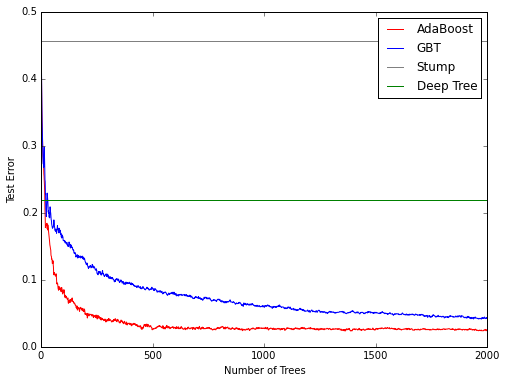

In [17]:
n_estimators = 2000
plt.figure(figsize = (8, 6))
plt.plot(range(1, n_estimators + 1), err_ada_test, 'r', label = 'AdaBoost')
plt.plot(range(1, n_estimators + 1), err_gbt_test, 'b', label = 'GBT')
plt.axhline(y = err_stump_test, color = 'gray',  label = 'Stump')
plt.axhline(y = err_tree_test,  color = 'green', label = 'Deep Tree')
plt.xlabel('Number of Trees')
plt.ylabel('Test Error')
plt.legend(loc = 1, framealpha = 1)

## Регуляризация

In [18]:
def draw_deviance(color, label, n_estimators = 2500, learning_rate = 1.0, 
                        subsample = 1.0, max_features = None):
    
    gbt_model = ensemble.GradientBoostingClassifier(
        max_leaf_nodes = 4, max_depth = None, 
        random_state = 2, min_samples_split = 5, 
        n_estimators = n_estimators, learning_rate = learning_rate, 
        subsample = subsample, max_features = max_features)
    gbt_model.fit(X_train, y_train)

    loss_test = []
    for y_pred in gbt_model.staged_decision_function(X_test):
        loss_test.append(gbt_model.loss_(y_test, y_pred))

    plt.plot(np.arange(n_estimators) + 1, loss_test, color = color, label = label)


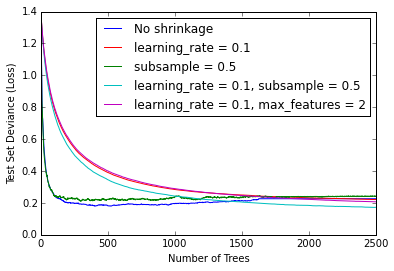

In [19]:
draw_deviance('b', 'No shrinkage',                          learning_rate = 1.0, subsample = 1.0)
draw_deviance('r', 'learning_rate = 0.1',                   learning_rate = 0.1, subsample = 1.0)
draw_deviance('g', 'subsample = 0.5',                       learning_rate = 1.0, subsample = 0.5)
draw_deviance('c', 'learning_rate = 0.1, subsample = 0.5',  learning_rate = 0.1, subsample = 0.5)
draw_deviance('m', 'learning_rate = 0.1, max_features = 2', learning_rate = 0.1, max_features = 2)

plt.legend(loc = 1)
plt.xlabel('Number of Trees')
plt.ylabel('Test Set Deviance (Loss)')

## Достоинства и недостатки ансамблей деревьев решений

### Достоинства:

* Все достоинства деревьев решений сохраняются (кроме возможности интерпретации решающего правила - но остается возможность определения значимости признаков)
* Хорошее (часто рекордное) качество предсказания
* Random Forest (почти) не переобучается (GBT, AdaBoost - чуть похуже)

### Недостатки:

* GBT, AdaBoost - много параметров, которые надо подбирать
* Медленно обучаются (особенно GBT, который требует обычно много деревьев)